In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scanpy, scprep
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gene_clusters = pd.read_csv('results/proliferation_2_clusters_top_hvgs.csv', index_col='Unnamed: 0')
cluster_names = gene_clusters['cluster'].unique()

In [23]:
gene_sets = {'BioPlanet_2019': ['Protein processing in the endoplasmic reticulum', 'Oxidative phosphorylation', 'Electron transport chain', 'Diabetes pathways', 'Gene expression regulation in pancreatic beta cells'],
             'GO_Biological_Process_2023': ['Regulation Of Insulin Secretion (GO:0050796)'],
             'Reactome_2022': ['Cellular Responses To Stress R-HSA-2262752'],
             'KEGG_2019_Human': ['Prolactin signaling pathway']}

In [29]:
gene_sets_tuples = []
for k,v in gene_sets.items():
    for path in v:
        gene_sets_tuples.append((k, path))

In [30]:
gene_cluster_map = {0: 'increasing', 1: 'decreasing'}

In [40]:
cluster_enrichment = {}
for cluster in tqdm(cluster_names[::-1]):
    genes = gene_clusters[gene_clusters['cluster'] == cluster]['human'].tolist()
    enr = gp.enrichr(gene_list=genes, # or "./tests/data/gene_list.txt",
                         gene_sets=['BioPlanet_2019', 'Panther_2016', 'KEGG_2019_Human', 'Reactome_2022', 'GO_Biological_Process_2023'],
                         organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                         outdir=None, # don't write to disk,
                         cutoff = 1
                        )
    res = enr.results[enr.results['Adjusted P-value'] < 0.05]
    res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
    res.to_csv(f'results/gene_cluster_{gene_cluster_map[cluster]}.csv')
    cluster_enrichment[cluster] = pd.concat([enr.results[(enr.results['Gene_set'] == x[0]) & (enr.results['Term'] == x[1])] for x in gene_sets_tuples])

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_113134/976439071.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
 50%|█████     | 1/2 [00:25<00:25, 25.35s/it]/tmp/ipykernel_113134/976439071.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
100%|██████████| 2/2 [00:50<00:00, 25.37s/it]


In [45]:
res = pd.DataFrame(gene_sets_tuples, columns=['Gene_set', 'Term'])
for cluster in cluster_names:
    gsea=[]
    for x in gene_sets_tuples:
        cluster_res = cluster_enrichment[cluster][(cluster_enrichment[cluster]['Gene_set'] == x[0]) & (cluster_enrichment[cluster]['Term'] == x[1])]
        if cluster_res.shape[0] == 1:
            gsea.append(cluster_res['Adjusted P-value'].iloc[0])
        else:
            gsea.append(np.nan)
    res[cluster] = gsea

In [47]:
res_increasing = res[res[0] < 0.05].sort_values(0)
res_decreasing = res[res[1] < 0.05].sort_values(1)

/tmp/ipykernel_113134/1491111335.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(np.hstack((np.log10(1/res_decreasing[1].values), np.log10(res_increasing[0].values))),


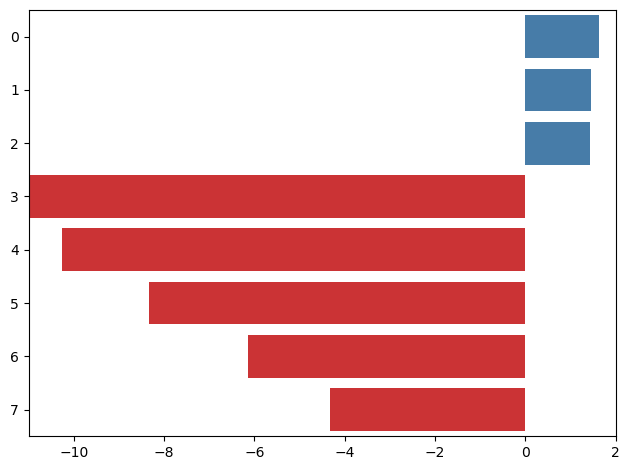

In [49]:
fig, ax = plt.subplots()
sns.barplot(np.hstack((np.log10(1/res_decreasing[1].values), np.log10(res_increasing[0].values))),
                 orient='h', ax=ax, palette=[sns.color_palette('Set1')[1]]*3 + [sns.color_palette('Set1')[0]]*5)
ax.set_xlim((-11,2))
plt.tight_layout()
fig.savefig('figures/GSEA_to_OBOB2.png', dpi=300)

/tmp/ipykernel_113134/567015321.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(res_increasing['Term'], rotation=90)


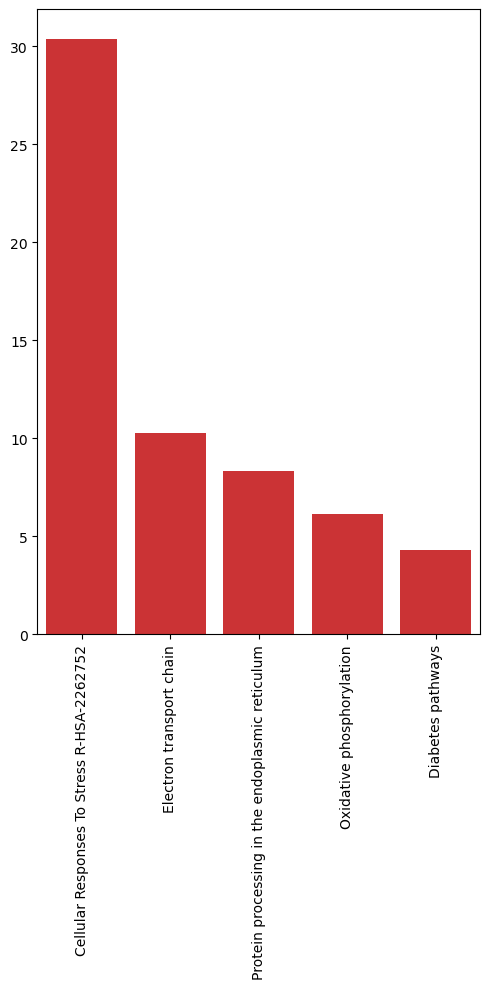

In [50]:
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(np.log10(1/res_increasing[0].values), color=sns.color_palette('Set1')[0], ax=ax)
ax.set_xticklabels(res_increasing['Term'], rotation=90)
plt.tight_layout()

/tmp/ipykernel_113134/615954445.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(res_decreasing['Term'], rotation=90)


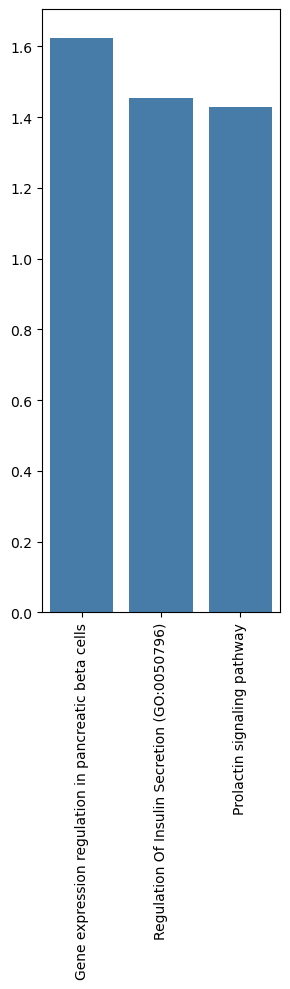

In [51]:
fig, ax = plt.subplots(figsize=(3,10))
sns.barplot(np.log10(1/res_decreasing[1].values), color=sns.color_palette('Set1')[1], ax=ax)
ax.set_xticklabels(res_decreasing['Term'], rotation=90)
plt.tight_layout()
fig.savefig('figures/decreasing_gsea_wt4.png', dpi=300)